<a href="https://colab.research.google.com/github/Dichik/gathers-nlp-final-project/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [119]:
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [177]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["TOKENIZERS_PARALLELISM"]="true"
import calendar

import pandas as pd
import numpy as np 
import gensim
import nltk
import spacy
import re
import torch
import torch.nn as nn

from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk import tokenize
from wordcloud import WordCloud, STOPWORDS
from functools import reduce
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from copy import deepcopy
import json

%matplotlib inline

In [121]:
def read_file(path: str):
  f = open(path)
  data = json.load(f)

  dataset = []
  for i in data:
    try:
      text = i.get('message')
      dataset.append(text)
    except:
      print('error')
    
  f.close()
  return pd.DataFrame(dataset, columns=['Message'])

In [122]:
regular_news = read_file('/content/news.json')
poss_manipulations = read_file('/content/poss_manipulations.json')

In [123]:
regular_news.head()

,Message
0,🤡 У санкт-петербурзі закрили аеропорт через не...
1,🤡 Тепер збирають «на священну війну»\n\nШахраї...
2,💥 Уночі росіяни обстріляли Святогірськ і влучи...
3,
4,Влада російської Адигеї заявила про падіння не...


In [124]:
poss_manipulations.head()

,Message
0,#ЦПД_аналізує досьє пропагандистки ю.барановсь...
1,⏺#ЦПД_застерігає: ворожі медіа поширили «докум...
2,⏺#ЦПД_виявляє: станом на ранок 27.02.2023 окуп...
3,#ЦПД_розвінчує: Пропагандисти поширюють дезінф...
4,


In [125]:
poss_manipulations.dropna(inplace=True)

In [126]:
manipulation_news = poss_manipulations[poss_manipulations['Message'].str.contains('#ЦПД_попереджає|Маніпуляція|#ЦПД_аналізує')]


In [127]:
regular_news['is_manipulation'] = 0
manipulation_news['is_manipulation'] = 1

<ipython-input-127-85be5d8fe57c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  manipulation_news['is_manipulation'] = 1


In [128]:
dataset = pd.concat([regular_news, manipulation_news])

df = pd.DataFrame(dataset)
df.reset_index(inplace=True)
df.head()

,index,Message,is_manipulation
0,0,🤡 У санкт-петербурзі закрили аеропорт через не...,0
1,1,🤡 Тепер збирають «на священну війну»\n\nШахраї...,0
2,2,💥 Уночі росіяни обстріляли Святогірськ і влучи...,0
3,3,,0
4,4,Влада російської Адигеї заявила про падіння не...,0


In [129]:
df.isna().sum()

index              0
Message            1
is_manipulation    0
dtype: int64

In [130]:
df.dropna(inplace=True)
df.isna().sum()

index              0
Message            0
is_manipulation    0
dtype: int64

In [131]:
df['Message'] = df['Message'].astype(str)
df.head()

,index,Message,is_manipulation
0,0,🤡 У санкт-петербурзі закрили аеропорт через не...,0
1,1,🤡 Тепер збирають «на священну війну»\n\nШахраї...,0
2,2,💥 Уночі росіяни обстріляли Святогірськ і влучи...,0
3,3,,0
4,4,Влада російської Адигеї заявила про падіння не...,0


In [132]:
df['is_manipulation'].value_counts()

0    5999
1     531
Name: is_manipulation, dtype: int64

In [152]:
f = open('/content/stop_words.txt')

stop_words = []
for word in f:
  stop_words.append(word)

stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'inst', 'https'])
len(stop_words)

1990

In [160]:
nltk.download('punkt')
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

# stemming / lemmatization? - we have Україна, України, etc. in wordcloud

def process_row(text, join_back=True):
    result = []
    sentences = nltk.sent_tokenize(text)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 3 and not w.startswith("цпд_")]
        text = re.sub(r"https\S+", "", text)
        text = re.sub(r"\n+", ". ", text)
        for symb in ["!", ",", ":", ";", "?"]:
            text = re.sub(rf"\{symb}\.", symb, text)
        if len(filtered_words) > 0 and filtered_words[-1] == 'центр':
          filtered_words = filtered_words[:len(filtered_words) - 1]
        result.extend(filtered_words)
    if join_back:
        result = " ".join(result)
    return result

df['cleaned_text'] = df['Message'].apply(lambda x: process_row(str(x)))
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,index,Message,is_manipulation,cleaned_text
0,0,🤡 У санкт-петербурзі закрили аеропорт через не...,0,санкт петербурзі закрили аеропорт через невідо...
1,1,🤡 Тепер збирають «на священну війну»\n\nШахраї...,0,тепер збирають священну війну шахраї рясах зна...
2,2,💥 Уночі росіяни обстріляли Святогірськ і влучи...,0,уночі росіяни обстріляли святогірськ влучили ч...
4,4,Влада російської Адигеї заявила про падіння не...,0,влада російської адигеї заявила падіння невідо...
6,6,😄 На росії від самого ранку знову тривога\n\nВ...,0,росії самого ранку знову тривога ефірі руськог...


In [134]:
df.dropna(inplace=True)
df.head()

,index,Message,is_manipulation,cleaned_text
0,0,🤡 У санкт-петербурзі закрили аеропорт через не...,0,санкт петербурзі закрили аеропорт через невідо...
1,1,🤡 Тепер збирають «на священну війну»\n\nШахраї...,0,тепер збирають на священну війну шахраї рясах ...
2,2,💥 Уночі росіяни обстріляли Святогірськ і влучи...,0,уночі росіяни обстріляли святогірськ влучили ч...
3,3,,0,
4,4,Влада російської Адигеї заявила про падіння не...,0,влада російської адигеї заявила про падіння не...


In [135]:
df = df[df['Message'].apply(len) > 3]
df.head()

,index,Message,is_manipulation,cleaned_text
0,0,🤡 У санкт-петербурзі закрили аеропорт через не...,0,санкт петербурзі закрили аеропорт через невідо...
1,1,🤡 Тепер збирають «на священну війну»\n\nШахраї...,0,тепер збирають на священну війну шахраї рясах ...
2,2,💥 Уночі росіяни обстріляли Святогірськ і влучи...,0,уночі росіяни обстріляли святогірськ влучили ч...
4,4,Влада російської Адигеї заявила про падіння не...,0,влада російської адигеї заявила про падіння не...
6,6,😄 На росії від самого ранку знову тривога\n\nВ...,0,на росії від самого ранку знову тривога ефірі ...


In [136]:
X = df['cleaned_text']
y = df['is_manipulation']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.33)

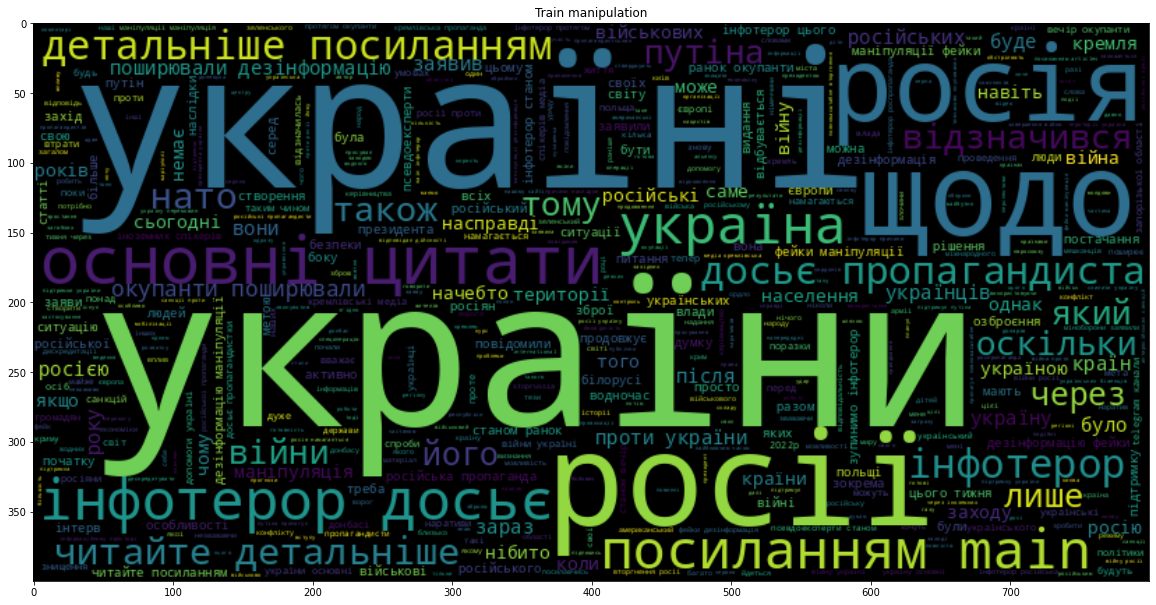

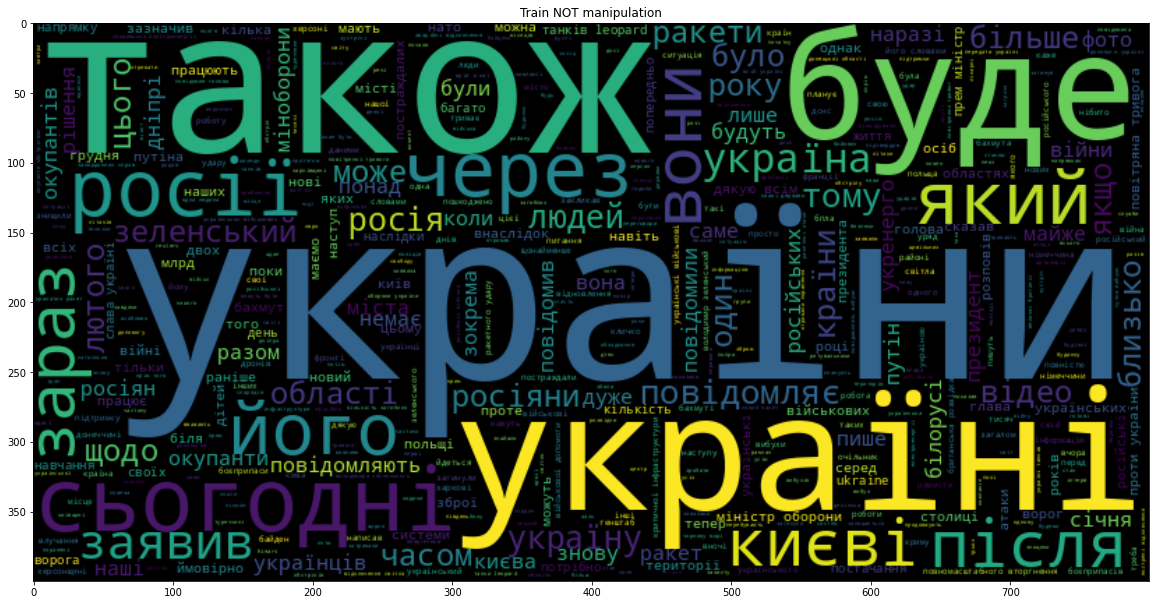

In [161]:
plt.figure(figsize = (20,20)) 
plt.title("Train manipulation")
wc = WordCloud(max_words = 500 , width = 800 , height = 400 , stopwords = stop_words).generate(" ".join(df.loc[df["is_manipulation"] == 1, 'cleaned_text']))
plt.imshow(wc, interpolation = 'bilinear')

plt.figure(figsize = (20,20)) 
plt.title("Train NOT manipulation")
wc = WordCloud(max_words = 500 , width = 800 , height = 400 , stopwords = stop_words).generate(" ".join(df.loc[df["is_manipulation"] == 0, 'cleaned_text']))
plt.imshow(wc, interpolation = 'bilinear')

In [168]:
def comp_metric(y_true, y_pred):
    assert y_true.shape == y_pred.shape
    class_roc_aucs = roc_auc_score(y_true, y_pred)
    print(f"Result Roc Auc: {class_roc_aucs}")
    return class_roc_aucs, np.mean(class_roc_aucs)

## Clustering

In [ ]:
# TODO maybe we can find smth interesting

## TF-IDF

In [158]:
tf_idf_object = TfidfVectorizer()
tf_idf_matrix = tf_idf_object.fit_transform(
    df["cleaned_text"].iloc[:6005]
)
print(f"Bag of Words: {tf_idf_object.get_feature_names_out()}")
print(
    f"Text : {df['cleaned_text'].iloc[1]}\n"
    f"Vectorization: {tf_idf_object.transform([df['cleaned_text'].iloc[1]]).toarray()[0]}"
)

Bag of Words: ['0010' '0246' '0323' ... 'ґрунту' 'ґрунтувався' 'ґрунті']
Text : тепер збирають священну війну шахраї рясах знайшли новий спосіб виманювати гроші русні центр
Vectorization: [0. 0. 0. ... 0. 0. 0.]


## Sentence Transformers

## Logistic Regression

In [178]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
folds_train_test_ids = [el for el in skf.split(X_train, y_train)]
# FIXME add k-fold

In [176]:
model = Pipeline([
    ("vectorizer", CountVectorizer()),
    ("lof_reg", LogisticRegression())
])

all_train_pred = model.fit(
    X_train, 
    y_train
).predict_proba(X_train)

all_train_pred = np.stack([el[1] for el in all_train_pred])

comp_metric(y_train.values, all_train_pred)

(3408,)
(3408, 2)
Result Roc Auc: 1.0


(1.0, 1.0)

In [181]:

all_train_preds = []
all_test_preds = []
all_train_targets = []
all_test_targets = []
all_models = []
for fold_id, (train_ids, test_ids) in enumerate(folds_train_test_ids):
    parameters = {
        'model__C': [.01, .1, 1, 10],
        'model__penalty': ['l1', 'l2']
    }
    pipeline = Pipeline([
        ("vectorizer", TfidfVectorizer()),
        ("model", LogisticRegression())
    ])
    # print(LogisticRegression().get_params().keys())
    grid = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=parameters)
    grid.fit(X_train.iloc[train_ids], y_train.iloc[train_ids])
    fold_train_preds = grid.predict_proba(X_train.iloc[train_ids])
    fold_train_preds = np.stack([el[1] for el in fold_train_preds])
    fold_test_preds = grid.predict_proba(X_train.iloc[test_ids])
    fold_test_preds = np.stack([el[1] for el in fold_test_preds])
    fold_train_targets = y_train.iloc[train_ids].values
    fold_test_targets = y_train.iloc[test_ids].values
    print(f"Fold {fold_id}")
    print("Train: ")
    comp_metric(fold_train_targets, fold_train_preds);
    print("Test: ")
    comp_metric(fold_test_targets, fold_test_preds);
    all_train_preds.append(fold_train_preds)
    all_test_preds.append(fold_test_preds)
    all_train_targets.append(fold_train_targets)
    all_test_targets.append(fold_test_targets)
    all_models.append(grid)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  Fil

Fold 0
Train: 
Result Roc Auc: 1.0
Test: 
Result Roc Auc: 0.9998875317722743


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  Fil

Fold 1
Train: 
Result Roc Auc: 0.9999999999999999
Test: 
Result Roc Auc: 0.9999775063544548


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  Fil

Fold 2
Train: 
Result Roc Auc: 0.9999999999999999
Test: 
Result Roc Auc: 1.0


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  Fil

Fold 3
Train: 
Result Roc Auc: 1.0
Test: 
Result Roc Auc: 1.0


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  Fil

Fold 4
Train: 
Result Roc Auc: 1.0
Test: 
Result Roc Auc: 0.999932408074982


## RNN

In [ ]:
class RNN(nn.Module):
    
    def __init__(
        self,
        num_embeddings,
        out_channels,
        rnn_channels=512,
        rnn_type=nn.GRU,
    ):
        super().__init__()
        pass        
        
    def forward(self, x):
        pass
        
        

## Transformers

## Evaluation

## References

- https://github.com/skupriienko/Ukrainian-Stopwords